# 日経平均株価 週足 メディアン統計

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import datetime
import os

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import yfinance as yf

from funcs.technical import calc_robust_bollinger

In [3]:
code = "N225"
symbol = "^%s" % code
yticker = yf.Ticker(symbol)

In [4]:
### 最新のデータが取得されていることを確認 ###
yticker.history(period="5d", interval="1d")

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2026-02-16 00:00:00+09:00,57212.968750,57219.199219,56748.179688,56806.410156,137400000,0.0,0.0
2026-02-17 00:00:00+09:00,56819.371094,56926.238281,56135.121094,56566.488281,132600000,0.0,0.0
2026-02-18 00:00:00+09:00,56734.269531,57392.890625,56734.269531,57143.839844,130100000,0.0,0.0
2026-02-19 00:00:00+09:00,57472.078125,57709.820312,57362.011719,57467.828125,135500000,0.0,0.0
2026-02-20 00:00:00+09:00,56979.738281,56979.738281,56680.878906,56825.699219,152400000,0.0,0.0


In [5]:
# 週足で過去 5 年分のデータを取得
df0 = yticker.history(period="10y", interval="1wk")

# ローソク足のチャートには、そのうち過去 3 年分のみ使用する
dt_last = df0.index[len(df0) - 1]
tdelta_2y = datetime.timedelta(days=365 * 2)
df = df0[df0.index >= dt_last - tdelta_2y]

In [6]:
dt = df.tail(1).index[0]
year_str = f"{dt.year:04d}"
date_str = f"{dt.month:02d}{dt.day:02d}"
date_str

'0216'

## Moving Median

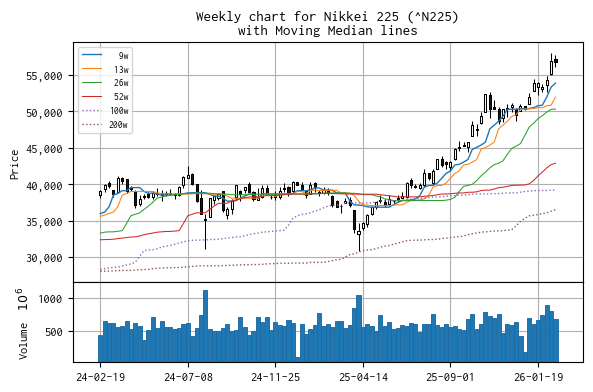

In [7]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 9

fig = plt.figure(figsize=(6, 4))
ax = dict()
n = 2
gs = fig.add_gridspec(
    n, 1, wspace=0.0, hspace=0.0, height_ratios=[3 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid()

mm09 = df0["Close"].rolling(9).median()
mm13 = df0["Close"].rolling(13).median()
mm26 = df0["Close"].rolling(26).median()
mm52 = df0["Close"].rolling(52).median()
mm100 = df0["Close"].rolling(100).median()
mm200 = df0["Close"].rolling(200).median()

apds = [
    mpf.make_addplot(mm09[df.index], width=1, label="  9w", ax=ax[0]),
    mpf.make_addplot(mm13[df.index], width=0.75, label=" 13w", ax=ax[0]),
    mpf.make_addplot(mm26[df.index], width=0.75, label=" 26w", ax=ax[0]),
    mpf.make_addplot(mm52[df.index], width=0.75, label=" 52w", ax=ax[0]),
    mpf.make_addplot(
        mm100[df.index],
        width=1,
        linestyle="dotted",
        label="100w",
        ax=ax[0],
    ),
    mpf.make_addplot(
        mm200[df.index],
        width=1,
        linestyle="dotted",
        label="200w",
        ax=ax[0],
    ),
]

mpf.plot(
    df,
    type="candle",
    style="default",
    volume=ax[1],
    datetime_format="%y-%m-%d",
    addplot=apds,
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax[0],
)

ax[0].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax[0].set_title(
    f"Weekly chart for {yticker.info["longName"]} ({symbol})\nwith Moving Median lines"
)
ax[0].legend(loc="upper left", fontsize=7)

plt.tight_layout()
plt.savefig(os.path.join(year_str, f"{date_str}_report_weekly_chart_median_{code}.png"))
plt.show()

In [8]:
df.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2026-02-09 00:00:00+09:00,55130.628906,58015.078125,55018.570312,56941.968750,796500000,0.0,0.0
2026-02-16 00:00:00+09:00,57212.968750,57709.820312,56135.121094,56825.699219,688000000,0.0,0.0


In [9]:
df.tail(2)["Close"]

Date
2026-02-09 00:00:00+09:00    56941.968750
2026-02-16 00:00:00+09:00    56825.699219
Name: Close, dtype: float64

In [10]:
df.tail(2)["Close"].diff()

Date
2026-02-09 00:00:00+09:00           NaN
2026-02-16 00:00:00+09:00   -116.269531
Name: Close, dtype: float64

In [11]:
df["Close"].rolling(9).median().tail(5)

Date
2026-01-19 00:00:00+09:00    50750.390625
2026-01-26 00:00:00+09:00    50836.550781
2026-02-02 00:00:00+09:00    51939.890625
2026-02-09 00:00:00+09:00    53322.851562
2026-02-16 00:00:00+09:00    53846.871094
Name: Close, dtype: float64

In [12]:
df["Close"].rolling(13).median().tail(5)

Date
2026-01-19 00:00:00+09:00    50491.871094
2026-01-26 00:00:00+09:00    50491.871094
2026-02-02 00:00:00+09:00    50750.390625
2026-02-09 00:00:00+09:00    50836.550781
2026-02-16 00:00:00+09:00    51939.890625
Name: Close, dtype: float64

In [13]:
df["Close"].rolling(26).median().tail(5)

Date
2026-01-19 00:00:00+09:00    48962.763672
2026-01-26 00:00:00+09:00    49403.429688
2026-02-02 00:00:00+09:00    49880.560547
2026-02-09 00:00:00+09:00    50265.140625
2026-02-16 00:00:00+09:00    50307.925781
Name: Close, dtype: float64

In [14]:
df["Close"].rolling(52).median().tail(5)

Date
2026-01-19 00:00:00+09:00    41127.916016
2026-01-26 00:00:00+09:00    41638.355469
2026-02-02 00:00:00+09:00    42226.884766
2026-02-09 00:00:00+09:00    42675.878906
2026-02-16 00:00:00+09:00    42868.609375
Name: Close, dtype: float64

In [15]:
df0["Close"].rolling(100).median().tail(5)

Date
2026-01-19 00:00:00+09:00    39120.300781
2026-01-26 00:00:00+09:00    39120.300781
2026-02-02 00:00:00+09:00    39120.300781
2026-02-09 00:00:00+09:00    39169.914062
2026-02-16 00:00:00+09:00    39169.914062
Name: Close, dtype: float64

In [16]:
df0["Close"].rolling(200).median().tail(5)

Date
2026-01-19 00:00:00+09:00    35830.384766
2026-01-26 00:00:00+09:00    35936.484375
2026-02-02 00:00:00+09:00    36060.644531
2026-02-09 00:00:00+09:00    36274.744141
2026-02-16 00:00:00+09:00    36486.615234
Name: Close, dtype: float64

## Robust Bollinger bands

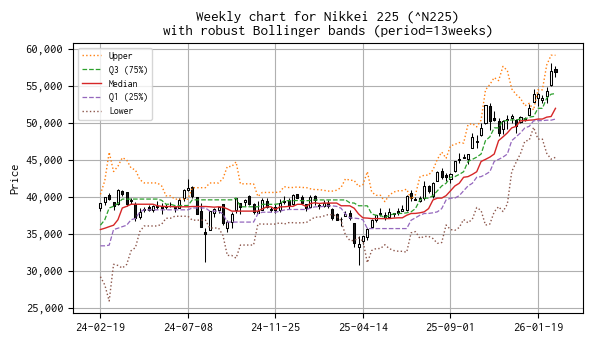

In [17]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 9

fig, ax = plt.subplots(figsize=(6, 3.5))

# Bollinger bands
period = 13
mv_median = df0["Close"].rolling(period).median()
mv_q1 = df0["Close"].rolling(period).quantile(0.25)
mv_q3 = df0["Close"].rolling(period).quantile(0.75)
mv_iqr = mv_q3 - mv_q1
mv_lower = mv_q1 - mv_iqr * 1.5
mv_upper = mv_q3 + mv_iqr * 1.5

apds = [
    mpf.make_addplot(
        mv_upper[df.index],
        width=1,
        color="C1",
        linestyle="dotted",
        label="Upper",
        ax=ax,
    ),
    mpf.make_addplot(
        mv_q3[df.index],
        width=0.9,
        color="C2",
        linestyle="dashed",
        label="Q3 (75%)",
        ax=ax,
    ),
    mpf.make_addplot(
        mv_median[df.index],
        width=1,
        color="C3",
        linestyle="solid",
        label="Median",
        ax=ax,
    ),
    mpf.make_addplot(
        mv_q1[df.index],
        width=0.9,
        color="C4",
        linestyle="dashed",
        label="Q1 (25%)",
        ax=ax,
    ),
    mpf.make_addplot(
        mv_lower[df.index],
        width=1,
        color="C5",
        linestyle="dotted",
        label="Lower",
        ax=ax,
    ),
]

mpf.plot(
    df,
    type="candle",
    style="default",
    addplot=apds,
    datetime_format="%y-%m-%d",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)

ax.grid()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.legend(loc="best", fontsize=7)

try:
    ax.set_title(
        f"Weekly chart for {yticker.info['longName']} ({symbol})\nwith robust Bollinger bands (period={period}weeks)"
    )
except KeyError:
    ax.set_title(
        f"Weekly chart for {symbol}\nwith robust Bollinger bands (period={period}weeks)"
    )

plt.tight_layout()
plt.savefig(
    os.path.join(
        year_str, f"{date_str}_report_weekly_chart_bollinger_robust_{code}.png"
    )
)
plt.show()

## ヒストグラムと Q-Q プロット

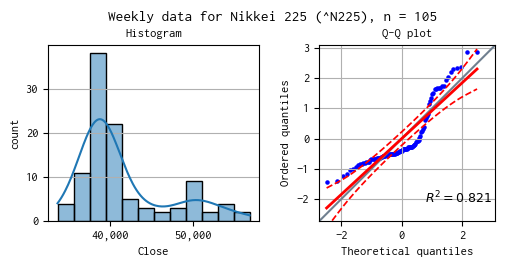

In [18]:
plt.rcParams["font.size"] = 9
fig, axes = plt.subplots(1, 2, figsize=(6, 2.5))

sns.histplot(df["Close"], kde=True, ax=axes[0])

# ヒストグラム
axes[0].set_xlabel("Close")
axes[0].set_ylabel("count")
axes[0].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
axes[0].grid(axis="y")
axes[0].set_title("Histogram", fontsize=9)

# Q-Q プロット
pg.qqplot(df["Close"], s=5, ax=axes[1])
axes[1].set_title("Q-Q plot", fontsize=9)
axes[1].grid()

plt.suptitle(
    "Weekly data for %s (%s), n = %d" % (yticker.info["longName"], symbol, len(df)),
    fontsize=11,
)
plt.subplots_adjust(top=0.84, bottom=0.135, wspace=0.2)
plt.savefig(
    os.path.join(year_str, f"{date_str}_report_weekly_histogram_qqplot_{code}.png")
)
plt.show()